### Importing Libaries ###

In [1]:
#Library imports
import re
import os
import time
import math
import random
import itertools
import numpy as np
import pandas as pd
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

#Notebook arguments
%matplotlib inline

# Importing Data

In [61]:
# Importing cleaned, timstamped and indexed data 
vix_arima = pd.read_pickle("vix_clean.pickle")

In [62]:
vix_arima.head()

,adjclose
Date,
2010-06-23,26.910000
2010-06-24,29.740000
2010-06-25,28.530001
2010-06-28,29.000000
2010-06-29,34.130001


In [63]:
#Sanity Check
vix_arima.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2010-06-23 to 2020-06-23
Data columns (total 1 columns):
adjclose    2518 non-null float64
dtypes: float64(1)
memory usage: 39.3 KB


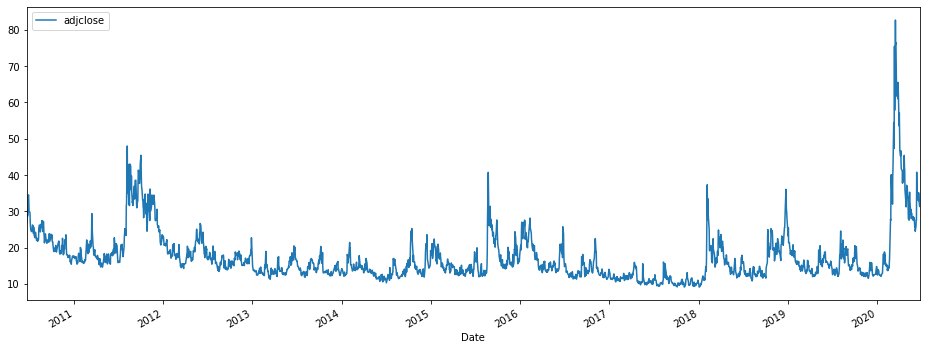

In [64]:
# Visualizing a line plot using vix and .plot() method 
vix_arima.plot(figsize = (16,6))

#### Some distinguishable patterns appear when we view the plotted data. The time-series has minimal seasonality pattern (as visible to our eyes). There have been a few distinct spikes and the overall trend seems to be follow key Index characteristic of 'long term mean reversion'

However the persistence of spikes and fluctations through the years cannot help us 'visually' decide whether this is a stationary series. We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise

### Time Series Decomposition ###

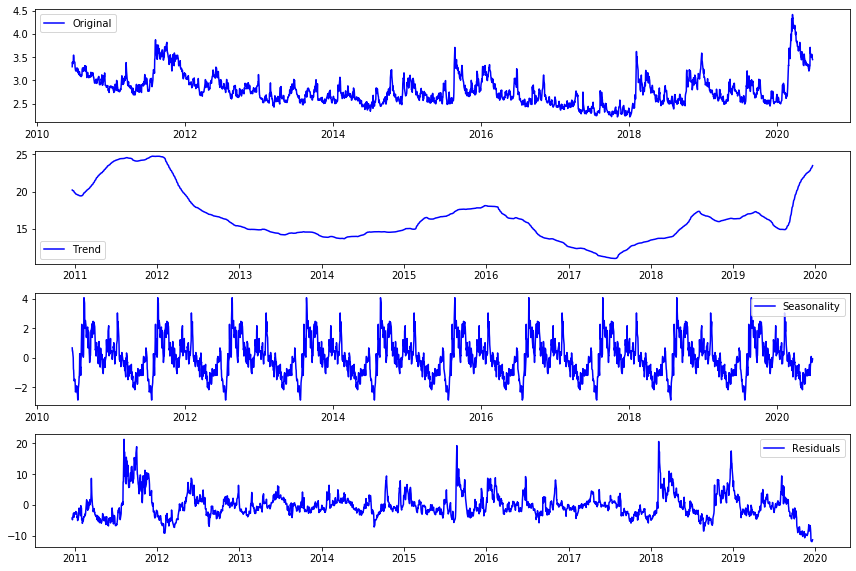

In [70]:
# Import and apply seasonal_decompose()
decomposition = seasonal_decompose(vix_arima,freq=252)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(vix_clean), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

#### Time series decomposition gives a more in-depth look into the underlying patterns in our data. Clearly the trend exhibits the aspect of long term mean reversion for the most part except for extended periods of heightened volatility relating to major world economic crises and disasters

There seems to be a strong pattern in seasonality which we found interesting that may relate to investor investment cycles. Lastly the residuals appear normal except for phases in time when there is considerable deviation again due to extended periods of volatility 

Clearly we need to confirm and check that this series is not stationary before moving ahead.

### Stationarity Check  - Rolling statistics and The Dickey-Fuller Test
In rolling statistics, we can plot the moving average or moving variance and see if it varies with time. By moving average/variance we mean at any point in time 𝑡 , we can take the average/variance of the 𝑚 last time periods. 𝑚 is then known as the window size

The Dickey-Fuller test is a statistical test for testing stationarity. The null-hypothesis for the test is that the time series is not stationary. So if the test statistic is less than the critical value, we reject the null hypothesis and say that the series is stationary

In [74]:
# Import the check_stationarity function from Learn Lesson on Time Series Decomposition
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=5, center=False).mean()
    roll_std = TS.rolling(window=5, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS['adjclose']) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

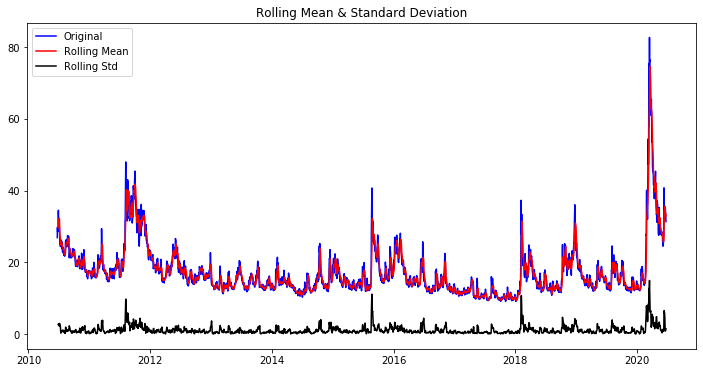

Results of Dickey-Fuller Test: 

Test Statistic                   -5.013100
p-value                           0.000021
#Lags Used                       10.000000
Number of Observations Used    2507.000000
Critical Value (1%)              -3.432961
Critical Value (5%)              -2.862694
Critical Value (10%)             -2.567384
dtype: float64


In [75]:
# Check stationarity
stationarity_check(vix_arima)

#### By breaking out the component factors, when inspecting the remaining residuals we can see that our test statistic is less than our desired threshold of 5% or even 1%, so we can reject the null hypothesis that this is not a stationary series and move on the next step of the process. But before I do that, I wanted to check if the exponential weighted moving average (ewm) could provide some additonal insight in the 'relative volatility' concept popularised by some academic papers  


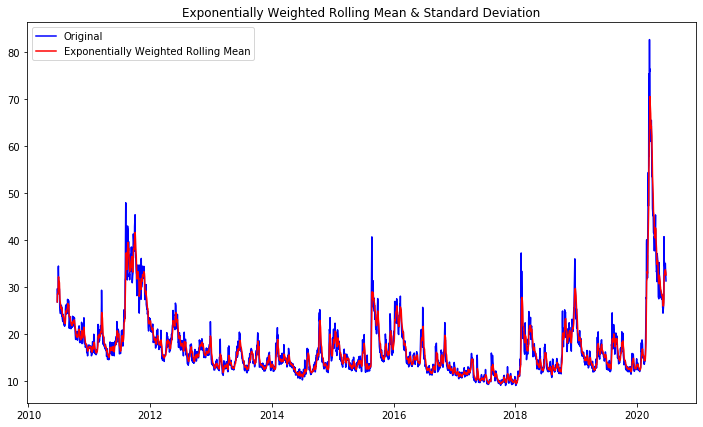

In [84]:
# Use Pandas ewm() to calculate Exponential Weighted Moving Average
exp_roll_mean = vix_arima.ewm(halflife=2).mean()

# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
orig = plt.plot(vix_arima, color='blue',label='Original')
mean = plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.title('Exponentially Weighted Rolling Mean & Standard Deviation')
plt.show(block=False)

There isn't much to be gleaned from the EWM visualization so I decided to explore whether differencing could provide some additional insight before moving on with the next step of the process - identifying autocorrelation and partial autocorrelation in the data

### Differencing ###

In [92]:
# first order of difference
data_diff = vix_arima.diff(periods=1)
data_diff.head(10)

,adjclose
Date,
2010-06-23,NaN
2010-06-24,2.830000
2010-06-25,-1.209999
2010-06-28,0.469999
2010-06-29,5.130001
2010-06-30,0.410000
2010-07-01,-1.680000
2010-07-02,-2.740000
2010-07-06,-0.470001


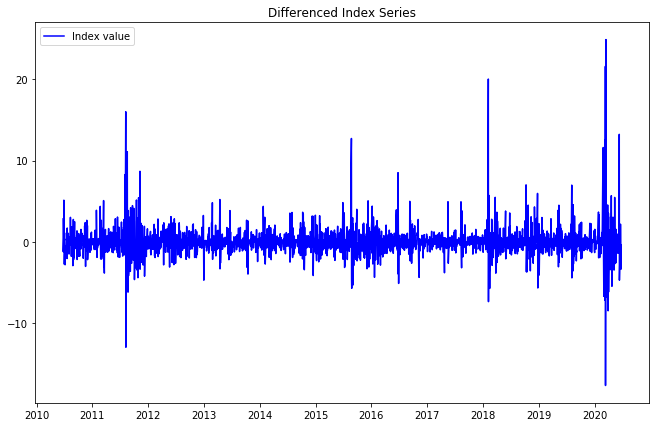

In [93]:
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='blue',label='Index value')
plt.legend(loc='best')
plt.title('Differenced Index Series')
plt.show(block=False)

### Auto-Correlation (ACF)

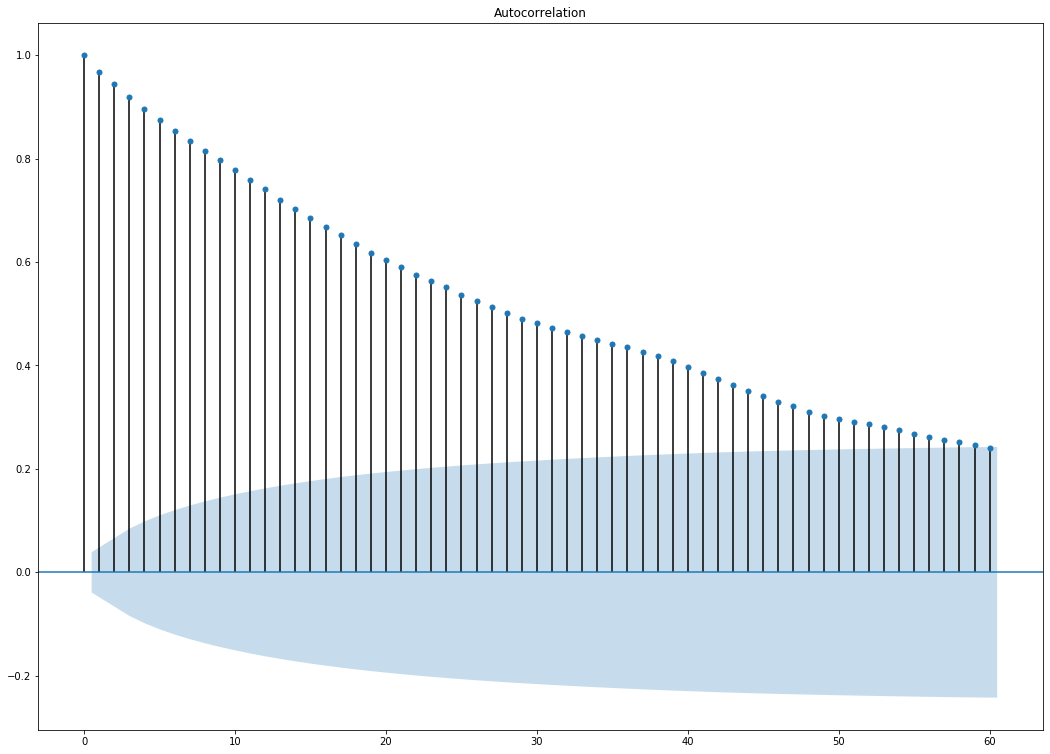

In [81]:
rcParams['figure.figsize'] = 18, 13
plot_acf(vix_arima, alpha=.05, lags=5*12)
plt.show()

### Partial Auto-Correlation (PACF)

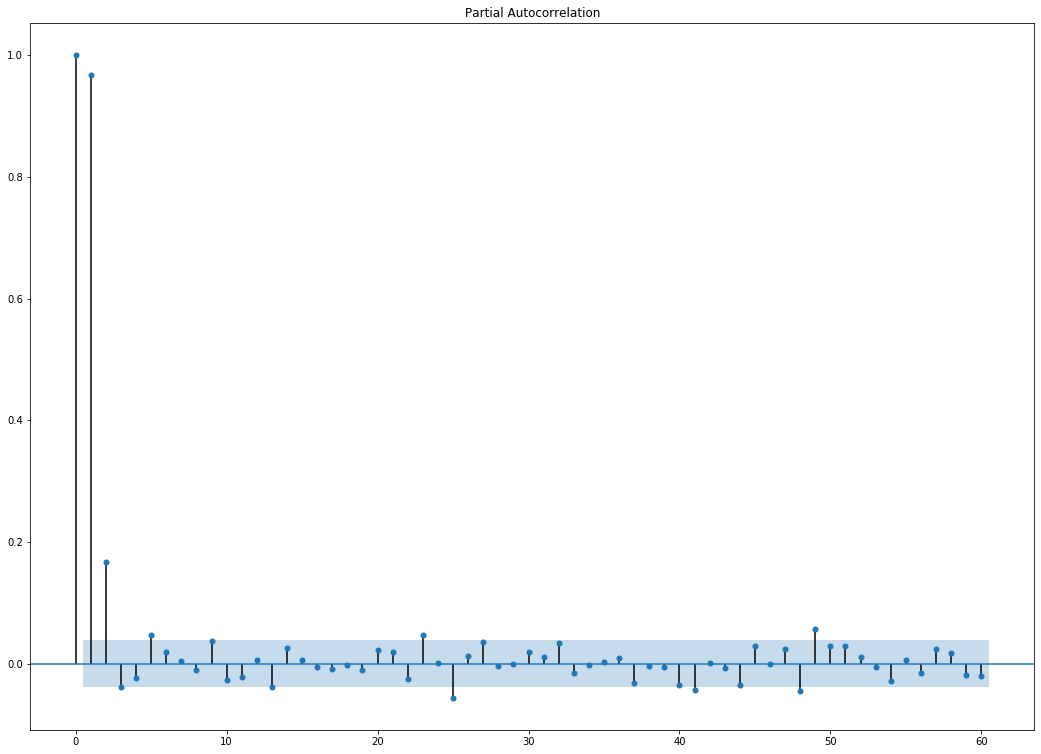

In [82]:
rcParams['figure.figsize'] = 18, 13
plot_pacf(vix_arima, alpha=.05, lags=5*12)
plt.show()


Based on this analysis of the ACF & PACF, I am ready to start building a baseline model. But before we do that, we need to split our data into training and testing datasets for validation purposes

### Let's commence the train, test, and split ###

In [96]:
vix_arima_train, vix_arima_test = vix_arima[:"2020-06-15"], vix_arima["2020-06-15":]

### Baseline - Persistence Model###

In [87]:
series = vix_arima['adjclose']
# Create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
print(dataframe.head(5))


         t-1        t+1
0        NaN  26.910000
1  26.910000  29.740000
2  29.740000  28.530001
3  28.530001  29.000000
4  29.000000  34.130001


In [88]:
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.995)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]


In [89]:
# persistence model
def model_persistence(x):
    return x

In [90]:
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

Test MSE: 17.164


In [95]:
rmse = math.sqrt(test_score)
print(rmse)

4.142918208777295


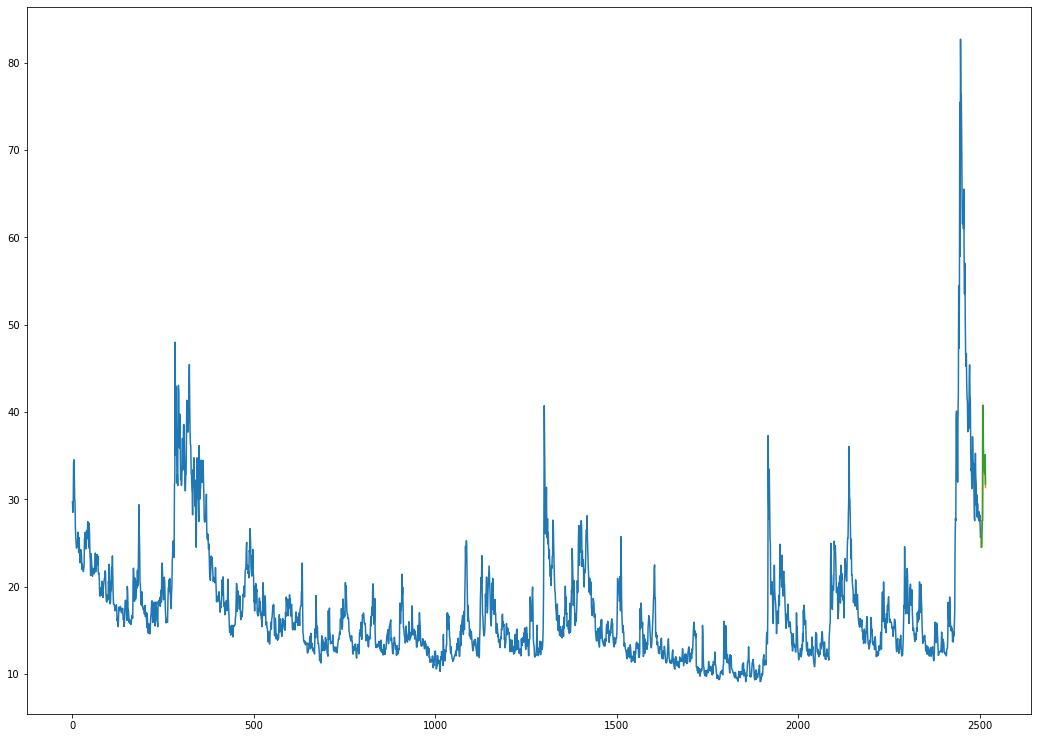

In [91]:
# plot predictions and expected results
pyplot.plot(train_y)
pyplot.plot([None for i in train_y] + [x for x in test_y])
pyplot.plot([None for i in train_y] + [x for x in predictions])
pyplot.show()

#### As the MSE suggests, the base model isnt effective at predicting the index. Lets try a more complex model - ARIMA####

### ARIMA - Hyperparameter Tuning and Model 

In [ ]:
def pdq_combinations(season_period, max_p, max_d, max_q):
    """Generates a list of combinations for pdq values to be passed into the hyperparameter search function."""

    p, d, q = range(0, max_p+1), range(0, max_d+1), range(0, max_q+1)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], season_period) for x in pdq]
    return pdq, seasonal_pdq

def pdq_hyperparam_search(df, season_period, max_p=1, max_d=1, max_q=1):
    """Generates and searches a list of pdq and season values to find best hyperparameters."""

    pdq, seasonal_pdq = pdq_combinations(season_period, max_p, max_d, max_q)
    all_results=[]
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(df, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
                results = mod.fit()
                rmse = math.sqrt(results.mse)
                print('ARIMA{}x{}12 - rmse:{}'.format(param, param_seasonal, rmse))
                all_results.append([param, param_seasonal, rmse])
            except:
                continue
    return pd.DataFrame(all_results, columns = ["PDQ", "S-PDQ", "Error"]).sort_values("Error", ascending=True).reset_index(drop=True)

def pdq_hyperparam_df_search(df, pdq_params, new_period=None, n_combs=5):
    """Like pdq_hyperparam search, but iterates through a specific amount of values in a DataFrame. Used to check values if initial data needed resampling
    for speed."""


In [ ]:
pdq_params